In [1]:
from keras.layers import LSTM, Bidirectional, Embedding, Input, Flatten, Dense, BatchNormalization, Dropout, Conv1D, Concatenate, MaxPool1D, AveragePooling1D, GlobalAveragePooling1D, GlobalMaxPool1D, SpatialDropout1D, TimeDistributed, Lambda 

Using TensorFlow backend.


In [2]:
from keras.layers import Add

In [3]:
from keras.optimizers import Adam

In [4]:
import keras
import tensorflow as tf
import keras.backend as K
from keras.models import Model

In [5]:
from keras.preprocessing.sequence import pad_sequences

In [6]:
from keras.utils import plot_model

In [7]:
import numpy as np
import math

In [8]:
import joblib
from sklearn.metrics import roc_auc_score

In [9]:
from layer_normalization import LayerNormalization

In [10]:
def pepare_train_test(file, tokenizer,sample=None):
    import pandas as pd
    from sklearn.model_selection import train_test_split
    train_df = pd.read_csv(file)
    train_binary = np.zeros((len(train_df),))
    train_binary[train_df['target']>0.5] = 1
    train_df['target_binary'] = train_binary
    train, test  = train_test_split(train_df, test_size=0.2, random_state=42,stratify=train_df['target_binary'])
    if sample:
        train = train.sample(sample)
        test = test.sample(int(sample/10))
    return tokenizer.texts_to_sequences(train['comment_text'].tolist()), train['target_binary'].values, tokenizer.texts_to_sequences(test['comment_text'].tolist()), test['target_binary'].values


In [11]:
embedding = joblib.load('./embedding')

In [12]:
tokenizer = joblib.load('./tokenizer')

In [13]:
trainx, trainy, testx, testy = pepare_train_test('train.csv', tokenizer)

In [14]:
maxlen = 200

In [15]:
class RocAucEvaluation(keras.callbacks.Callback):
    def __init__(self, validation_data=(), interval=1):
        super(keras.callbacks.Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            y_orig_test = np.zeros(len(self.y_val))
            y_orig_test[self.y_val >= 0.5 ] = 1
            y_pred_scaled = np.zeros(y_pred.shape[0],)
            y_pred = y_pred.reshape(y_pred.shape[0],)
            y_pred_scaled[y_pred >= 0.5 ] = 1
            score = roc_auc_score(y_orig_test, y_pred_scaled)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

In [16]:
from time import time
callbacks_list = [
    # This callback will interrupt training when we have stopped improving
    keras.callbacks.EarlyStopping(
        # This callback will monitor the validation accuracy of the model
        monitor='val_loss',
        # Training will be interrupted when the accuracy
        # has stopped improving for *more* than 1 epochs (i.e. 2 epochs)
        patience=3,
    ),
    # This callback will save the current weights after every epoch
    keras.callbacks.ModelCheckpoint(
        filepath='models/best_model_transformer.h5',  # Path to the destination model file
        # The two arguments below mean that we will not overwrite the
        # model file unless `val_loss` has improved, which
        # allows us to keep the best model every seen during training.
        monitor='val_loss',
        save_best_only=True,
    ),
    keras.callbacks.TensorBoard(log_dir='./logs/{}'.format(time()), histogram_freq=0, batch_size=1024, update_freq='batch'),
    RocAucEvaluation(validation_data=(pad_sequences(testx,maxlen), testy), interval=1)

]

## Transformer Experiment, reference - https://arxiv.org/pdf/1706.03762.pdf

In [17]:
"""
Scaled Dot-Product Attention
"""
class SDPA(keras.layers.Layer):
    def __init__(self,output_dim, **kwargs):
        self.output_dim = output_dim
        super(SDPA,self).__init__(**kwargs)
    
    def build(self,input_shape):
        self.kernel_Q = self.add_weight(name='Q',
                                        shape=(input_shape[-1],self.output_dim),
                                        initializer='uniform',
                                        trainable=True
                                       )
        self.kernel_K = self.add_weight(name='K',
                                        shape=(input_shape[-1],self.output_dim),
                                        initializer='uniform',
                                        trainable=True
                                       )
        self.kernel_V = self.add_weight(name='V',
                                        shape=(input_shape[-1],self.output_dim),
                                        initializer='uniform',
                                        trainable=True
                                       )
    def call(self, x, mask=None):
        qvec = K.dot(x,self.kernel_Q)
        kvec = K.dot(x,self.kernel_K)
        vvec = K.dot(x,self.kernel_V)
#         print ("QVEC",qvec.shape)
#         print ("KVEC",kvec.shape)
        ktvec = K.permute_dimensions(kvec,(0,2,1))
#         print ("KTVEC",ktvec.shape)
        numerator = tf.einsum('ijk,ikz ->ijz',qvec,ktvec)
        smax = K.softmax((numerator/np.sqrt(self.output_dim)))
        final = tf.einsum('ijk,ikz ->ijz',smax,vvec)
        return final
    
    def compute_output_shape(self,input_shape):
        return(input_shape[0],input_shape[1],self.output_dim)

In [18]:
"""
Positional Encoder
"""
class PositionalEncoder(keras.layers.Layer):
    def __init__(self, **kwargs):
#         self.output_dim = output_dim
        super(PositionalEncoder,self).__init__(**kwargs)
     
    def build(self,input_shape):
        self.output_dim = input_shape[-1]
        def positional_encoding(shape, dtype=None):
            print ("PE shape is {}".format(shape))
            start = 0
            end = shape[1] // 2
            values = []
            for row in range(shape[0]):
                left = [math.sin(row/10000**((2*i)/shape[1])) for i in range(start,end)]
                right = [math.cos(row/10000**((2*i)/shape[1])) for i in range(start,end)]
                values.append(left+right)
            return np.array(values)
        self.kernel_pe = self.add_weight(name='pe',
                                        shape=(input_shape[-2],self.output_dim),
                                        initializer=positional_encoding,
                                        trainable=False
                                       )

    def call(self, x, mask=None):
        output = x+self.kernel_pe
        print ("The PE output shape is {}".format(output))
        return output
    
    def compute_output_shape(self,input_shape):
        return(input_shape[0],input_shape[1],self.output_dim)

In [19]:
def get_multi_head_attn(input, head_size, embedding_size,name="multi_head"):
    transformers = []
    for i in range(head_size):
        x1 = SDPA(100)(input)
#         xh = Dense(100, activation='relu')(x1)
        transformers.append(x1)
    x = Concatenate()(transformers)
    x = Dense(embedding_size, name=name)(x)
    return x
    

In [20]:
def get_transformer(input, head_size=5, embedding_size=100,index=0):
    multi_head = get_multi_head_attn(input, head_size, embedding_size, "multi_head_{}".format(index))
    add_out = Add()([multi_head, input])
    norm_out = LayerNormalization(name="multi_head_norm_{}".format(index))(add_out)

    ffout = TimeDistributed(Dense(embedding_size,activation='relu'))(norm_out)
    add_out = Add()([norm_out, ffout])
    norm_out = LayerNormalization(name="transformer_{}".format(index))(add_out)
    return norm_out

In [21]:
def get_transformer_model(multi_head_size,embedding,maxlen,depth=1):
    input = Input(shape=(maxlen,), name="input_sentence")
    x = Embedding(input_dim=embedding.shape[0], output_dim=embedding.shape[1], input_length=maxlen, weights=[embedding], trainable=False, mask_zero=False)(input)
    x = PositionalEncoder()(x)
    for i in range(depth):
        x = get_transformer(x,multi_head_size,embedding.shape[1],index=i)
#     x = Flatten()(x)
#     print(x.shape)
    maxoutput = MaxPool1D(20)(x)
    maxoutput = Flatten()(maxoutput)
    avgoutput = GlobalAveragePooling1D()(x)
    output = Concatenate()([maxoutput,avgoutput])
    output = Dense(512, activation='relu')(output)
    output = Dropout(0.2)(output)
    output = Dense(128, activation='relu')(output)
    output = Dropout(0.2)(output)
    output = Dense(32, activation='relu')(output)
    output = Dropout(0.2)(output)
    output = Dense(1, activation='sigmoid')(output)
    return Model(input,output)

In [22]:
model = get_transformer_model(3,embedding,maxlen,depth=2)

Instructions for updating:
Colocations handled automatically by placer.
PE shape is (200, 300)
The PE output shape is Tensor("positional_encoder_1/add:0", shape=(?, 200, 300), dtype=float32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [23]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_sentence (InputLayer)     (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 300)     30450300    input_sentence[0][0]             
__________________________________________________________________________________________________
positional_encoder_1 (Positiona (None, 200, 300)     60000       embedding_1[0][0]                
__________________________________________________________________________________________________
sdpa_1 (SDPA)                   (None, 200, 100)     90000       positional_encoder_1[0][0]       
__________________________________________________________________________________________________
sdpa_2 (SD

In [24]:
plot_model(model,'transformer.png')

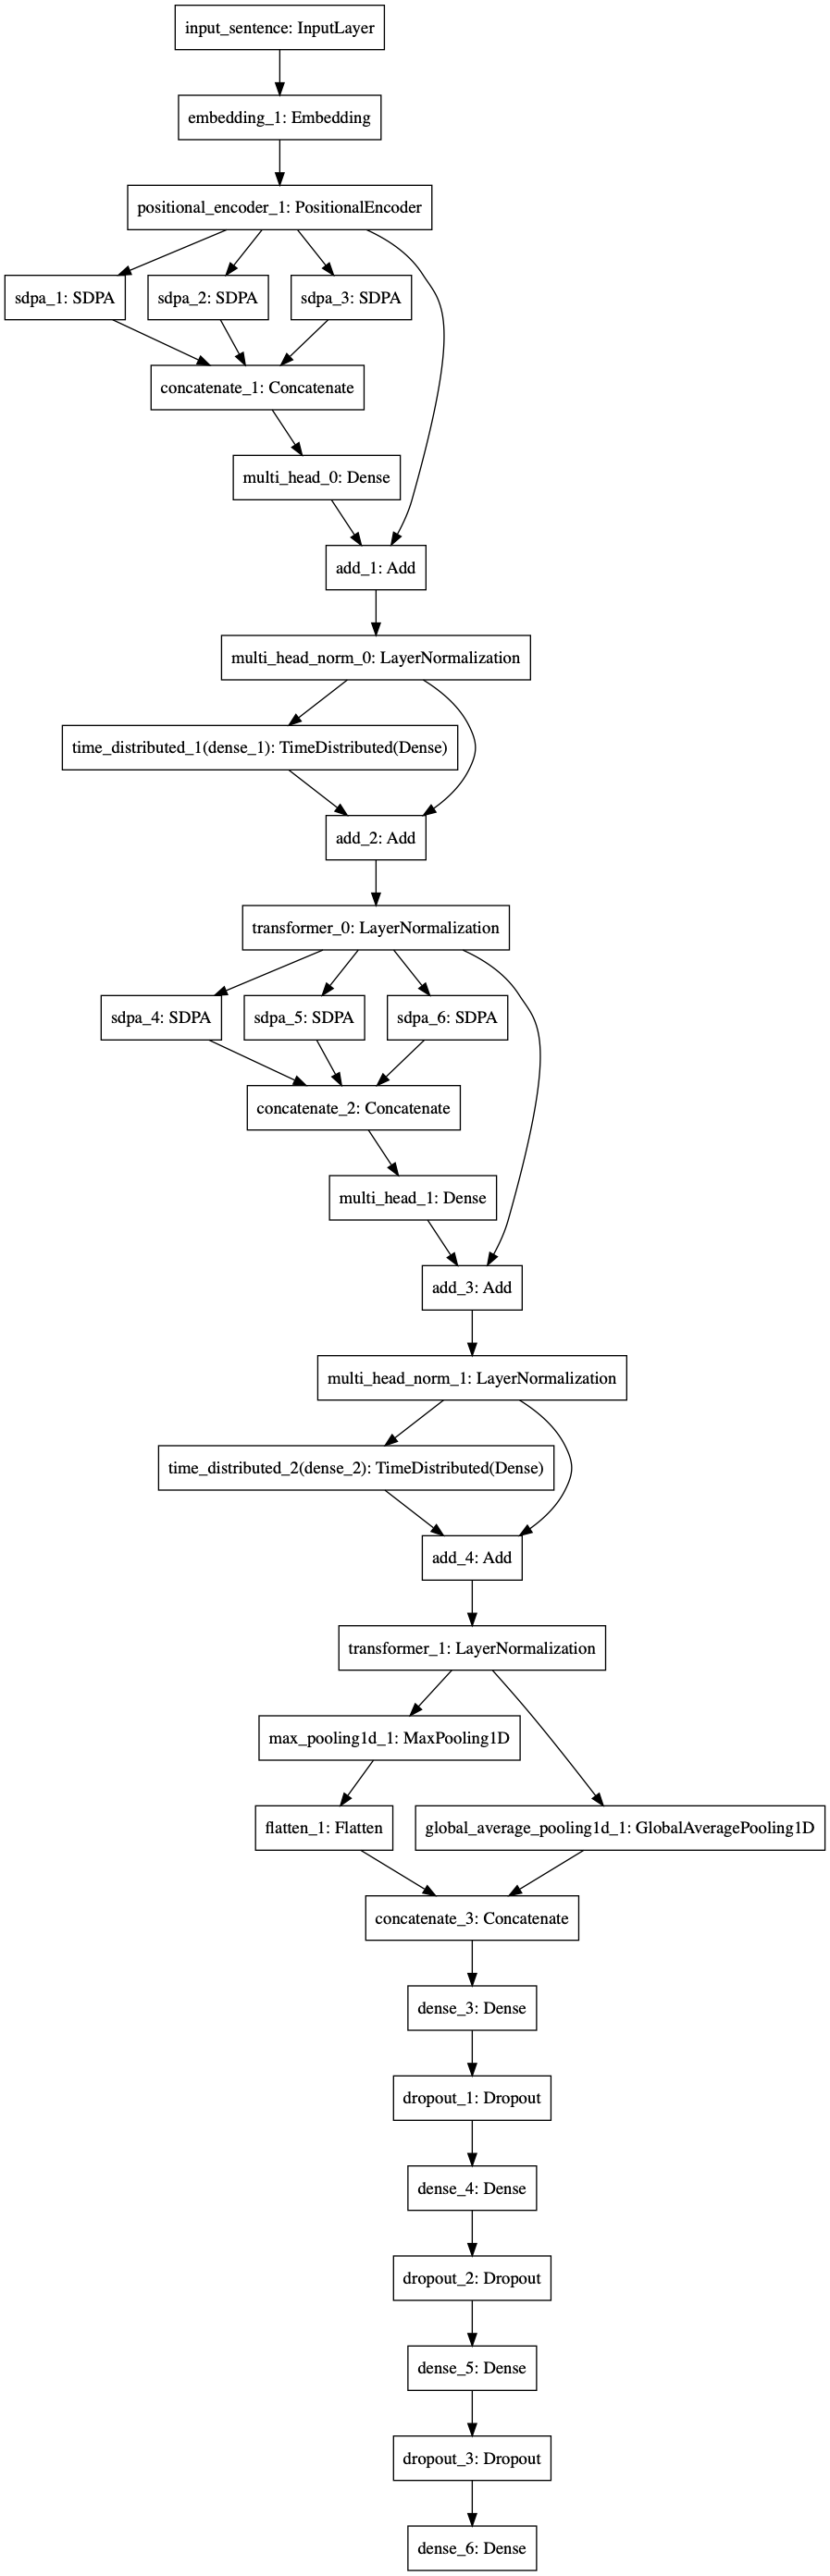

In [25]:
from IPython.display import Image
Image('transformer.png')

In [37]:
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['acc','mean_squared_error'])

In [38]:
model.fit(pad_sequences(trainx,maxlen), trainy, validation_data=(pad_sequences(testx,maxlen), testy),epochs=10, batch_size=64, callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Train on 1443899 samples, validate on 360975 samples
Epoch 1/10
 112256/1443899 [=>............................] - ETA: 6:21:49 - loss: 0.2407 - acc: 0.9409 - mean_squared_error: 0.0575

KeyboardInterrupt: 

In [144]:
# model.save('transformer_without_pe_epoch1.h5')